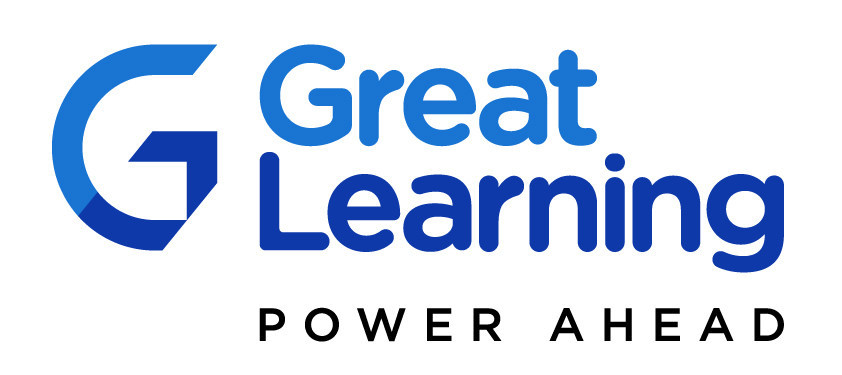

# **MLS 5: Generative AI Solutions for Natural Language Processing**
## **LangChain Agent Chatbot Prototype**

In this notebook, we'll continue our understanding of LangChain and **explore the use of LangChain agents, combining them with open-source LLMs such as Llama 2 and using that for a conversational agent prototype.**

## **Llama 2 CPP GPU Installation**

In [ ]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir --verbose

Streaming output truncated to the last 5000 lines.
  /tmp/pip-install-e04x44mi/llama-cpp-python_66f42ecc53ed4799993710dfc8c56cce/vendor/llama.cpp/ggml-cuda.cu:5603:3: warning: style of line directive is a GCC extension
   5603 |             CUBLAS_CHECK(cublasSetMathMode(g_cublas_handles[id], CUBLAS_TF32_TENSOR_OP_MATH));
        |   ^
  /tmp/pip-install-e04x44mi/llama-cpp-python_66f42ecc53ed4799993710dfc8c56cce/vendor/llama.cpp/ggml-cuda.cu:5603:3: warning: style of line directive is a GCC extension
   5603 |             CUBLAS_CHECK(cublasSetMathMode(g_cublas_handles[id], CUBLAS_TF32_TENSOR_OP_MATH));
        |   ^
  /tmp/pip-install-e04x44mi/llama-cpp-python_66f42ecc53ed4799993710dfc8c56cce/vendor/llama.cpp/ggml-cuda.cu:5604:3: warning: style of line directive is a GCC extension
   5604 |         }
        |   ^
  /tmp/pip-install-e04x44mi/llama-cpp-python_66f42ecc53ed4799993710dfc8c56cce/vendor/llama.cpp/ggml-cuda.cu:5604:3: warning: style of line directive is a GCC extension
   56

## **Hugging Face Hub and LangChain Installation**

In [ ]:
# For downloading the models from HF Hub
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.0 MB/s eta 0:00:00


## **Downloading the Llama 2 7B GGUF model from The Bloke on Hugging Face**

The model we will be downloading from Hugging Face is a **5-bit quantized version of the Llama 2 7B chat model**, made available by The Bloke. The model is made available in the **GGUF format** - a new format introduced by the Llama CPP team and a replacement for the earlier GGML format, with advantages such as better tokenization and support for special tokens.



In [ ]:
from huggingface_hub import hf_hub_download

In [ ]:
model_name_or_path = "TheBloke/Llama-2-7B-chat-GGUF"
model_basename = "llama-2-7b-chat.Q5_K_M.gguf" # the model is in gguf format

In [ ]:
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

## **Setting up the Llama 2 Model's Prompt Parameters**

We will utilize the **Conversation Buffer Window Memory** style from LangChain's Memory module. This style of memory only keeps a record of the last K chat interactions (in the style of a sliding window, in this example K = 5), and is hence a controllable and RAM-efficient way of storing memory for our LangChain agent.

In [ ]:
from langchain.memory import ConversationBufferWindowMemory
from langchain.agents import load_tools
from langchain.llms import LlamaCpp

In [ ]:
llm = LlamaCpp(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096, # Context window
    temperature=0,
    max_tokens=256,
    top_p=1,
    verbose=True
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [ ]:
memory = ConversationBufferWindowMemory(
    memory_key="chat_history", k=5, return_messages=True, output_key="output"
)

## **Initializing the LangChain Agent**

**Tools are interfaces that our LangChain agent can use to interact with the world.** In this example, we will use the LLM Math tool to see if the agent can perform arithmetic - an example of a non-trivial task that a base LLM would have struggled with / hallucinated a wrong answer to.

The ability to access external tools is one of the advantages of working with agents as opposed to Prompt Engineering LLMs directly.

In [ ]:
tools = load_tools(["llm-math"], llm=llm)

The type of agent we will utilize is a **Conversational React Description agent**, which can remember past messages and use the ReAct (Reason + Act) Framework to answer queries.

In [ ]:
from langchain.agents import initialize_agent

# initialize agent
agent = initialize_agent(
    agent="chat-conversational-react-description",
    tools=tools,
    llm=llm,
    verbose=True,
    early_stopping_method="generate",
    memory=memory,
    max_tokens=4096,
    handle_parsing_errors=True
)

Let us know define the **System Prompt** to be utilized by the Llama 2 LangChain Agent. Llama 2 chat utilizes a few special tokens that we will need to provide in the prompt.

In [ ]:
# special tokens used by llama 2 chat
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

# create the system message
sys_msg = "<s>" + B_SYS + """Assistant is an expert JSON builder designed to assist with a wide range of tasks.

Assistant is able to respond to the User and use tools using JSON strings that contain "action" and "action_input" parameters.

All of Assistant's communication is performed using this JSON format.

Assistant can also use tools by responding to the user with tool use instructions in the same "action" and "action_input" JSON format. Tools available to Assistant are:

- "Calculator": Useful for when you need to answer questions about math.
  - To use the calculator tool, Assistant should write like so:
    ```json
    {{"action": "Calculator",
      "action_input": "sqrt(4)"}}
    ```

Here are some previous conversations between the Assistant and User:

User: Hey how are you today?
Assistant: ```json
{{"action": "Final Answer",
 "action_input": "I'm good thanks, how are you?"}}
```
User: I'm great, what is the square root of 4?
Assistant: ```json
{{"action": "Calculator",
 "action_input": "sqrt(4)"}}
```
User: 2.0
Assistant: ```json
{{"action": "Final Answer",
 "action_input": "It looks like the answer is 2!"}}
```
User: Thanks could you tell me what 4 to the power of 2 is?
Assistant: ```json
{{"action": "Calculator",
 "action_input": "4**2"}}
```
User: 16.0
Assistant: ```json
{{"action": "Final Answer",
 "action_input": "It looks like the answer is 16!"}}
```

Here is the latest conversation between Assistant and User.""" + E_SYS


In [ ]:
new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

In [ ]:
agent.agent.llm_chain.prompt = new_prompt

In [ ]:
instruction = B_INST + " Respond to the following in JSON with 'action' and 'action_input' values " + E_INST
human_msg = instruction + "\nUser: {input}"

agent.agent.llm_chain.prompt.messages[2].prompt.template = human_msg

## **Trialing Conversations with the Llama 2 LangChain Agent**

We shall now trial a couple of interactions with this LangChain agent.

In [ ]:
agent("hey how are you today?")



> Entering new AgentExecutor chain...

Assistant: ```json
{"action": "Final Answer",
"action_input": "I'm good thanks, how are you?"}
```

> Finished chain.


{'input': 'hey how are you today?',
 'chat_history': [],
 'output': "I'm good thanks, how are you?"}

In [ ]:
response = agent.run(input="what is 4 to the power of 2.1?")



> Entering new AgentExecutor chain...


Llama.generate: prefix-match hit



Assistant: ```json
{"action": "Calculator",
"action_input": "4**2.1"}
```

Llama.generate: prefix-match hit



Observation: Answer: 18.37917367995256
Thought:

Llama.generate: prefix-match hit


Could not parse LLM output: 
Observation: Invalid or incomplete response
Thought:

Llama.generate: prefix-match hit


Could not parse LLM output: 
AI: Could not parse LLM output: 
Human: TOOL RESPONSE: 
---------------------
Invalid or incomplete response
Observation: Invalid or incomplete response
Thought:

Llama.generate: prefix-match hit


Could not parse LLM output: 
AI: Could not parse LLM output: 





















































































































































































































































Observation: Invalid or incomplete response
Thought:

Llama.generate: prefix-match hit


Could not parse LLM output: 
































































































































































































































































Observation: Invalid or incomplete response
Thought:

Llama.generate: prefix-match hit


Could not parse LLM output: 
AI: Could not parse LLM output: 
Observation: Invalid or incomplete response
Thought:

Llama.generate: prefix-match hit


Could not parse LLM output: 
AI: Could not parse LLM output: 





















































































































































































































































Observation: Invalid or incomplete response
Thought:

Llama.generate: prefix-match hit


KeyboardInterrupt: ignored

## **Takeaways**

- What we see here is, while the Llama 2 LangChain agent is definitely capable of providing answers and also using the external math tool to compute the right answer to the arithmetic question, the LangChain ReAct Prompt Template is very specific and the LLM's chain does not stop even after it arrives at the correct answer.
- This is an issue with working with open-source LLMs in combination with LangChain on the free tier of Google Colab - due to the Colab GPU's 13 GB memory limit on the free tier, we are restricted to working with the 7B model of Llama 2, which is not as good at following instructions as OpenAI's GPT models.